In [1]:
import tensorflow as tf
import numpy as np
import scipy.io as sio
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Configuration (si GPU disponible)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs disponibles: {len(gpus)}")
    except RuntimeError as e:
        print(e)
else:
    print("Aucun GPU détecté, utilisation du CPU.")

Aucun GPU détecté, utilisation du CPU.


In [2]:
# chargement des données
base_path = r"ENetFall_dataset_trained_networks"

dataset_files = [
    r"dataset_home_lab(L).mat",
    r"dataset_home_lab(R).mat",
    r"dataset_lecture_room.mat",
    r"dataset_living_room.mat",
    r"dataset_meeting_room.mat"
]

signals = []
labels = []

for file_name in dataset_files:
    path = fr"{base_path}\{file_name}"
    try:
        data_mat = sio.loadmat(path)
        signals.append(data_mat['dataset_CSI_t'])
        labels.append(data_mat['dataset_labels'].squeeze())
        print(f"Chargé: {file_name}, Signaux: {data_mat['dataset_CSI_t'].shape}, Étiquettes: {data_mat['dataset_labels'].squeeze().shape}")
    except Exception as e:
        print(f"Erreur avec {path}: {e}")

if not signals:
    raise ValueError("Aucune donnée n'a été chargée.")

data_all = np.concatenate(signals, axis=0)
labels_all = np.concatenate(labels, axis=0)

print(f"\nDonnées totales - signaux: {data_all.shape}, étiquettes: {labels_all.shape}")

Chargé: dataset_home_lab(L).mat, Signaux: (85, 625, 90), Étiquettes: (85,)
Chargé: dataset_home_lab(R).mat, Signaux: (85, 625, 90), Étiquettes: (85,)
Chargé: dataset_lecture_room.mat, Signaux: (205, 625, 90), Étiquettes: (205,)
Chargé: dataset_living_room.mat, Signaux: (248, 625, 90), Étiquettes: (248,)
Chargé: dataset_meeting_room.mat, Signaux: (134, 625, 90), Étiquettes: (134,)

Données totales - signaux: (757, 625, 90), étiquettes: (757,)


#### 1. On considére les 22 participants et les 4 environnements comme connus et on les intégre dans l’entrainement.

In [3]:
# prétraitement des données

# Reshape pour CNN: (Nombre d'échantillons, Hauteur, Largeur, Canaux)
# c'est ce qui est attendu en entrée dans un CNN
# (N, 625, 90) -> (N, 625, 30, 3) après réorganisation et transposition
instances = data_all.shape[0]
timesamples = data_all.shape[1] # 625
subcarriers = data_all.shape[2] # 90
width = subcarriers // 3 # 30

data = np.ndarray(shape=(instances, 3, timesamples, width))
data[:, 0, :, :] = data_all[:, :, 0:subcarriers:3]
data[:, 1, :, :] = data_all[:, :, 1:subcarriers:3]
data[:, 2, :, :] = data_all[:, :, 2:subcarriers:3]

# Transposer pour TensorFlow: (N, timesamples, width, 3)
data_tf = np.transpose(data, (0, 2, 3, 1))
print(f"Forme des données pour TensorFlow: {data_tf.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    data_tf, labels_all,
    test_size=0.25,
    random_state=42,
    stratify=labels_all
)

# normalisation
train_max = np.max(X_train)
train_mean = np.mean(X_train / train_max)

X_train_normalized = (X_train / train_max) - train_mean
X_test_normalized = (X_test / train_max) - train_mean

Forme des données pour TensorFlow: (757, 625, 30, 3)


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 623, 28, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 311, 14, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 309, 12, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 154, 6, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 152, 4, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 38912)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,490,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,546,817 (9.72 MB)

 Trainable params: 2,546,817 (9.72 MB)

 Non-trainable params: 0 (0.00 B)


Début de l'entraînement...
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5017 - loss: 0.6961 - precision: 0.3857 - recall: 0.2457 - val_accuracy: 0.5737 - val_loss: 0.7308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5784 - loss: 0.6783 - precision: 0.5647 - recall: 0.3342 - val_accuracy: 0.6158 - val_loss: 0.6516 - val_precision: 0.5417 - val_recall: 0.6420
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6809 - loss: 0.6146 - precision: 0.6737 - recall: 0.5906 - val_accuracy: 0.6789 - val_loss: 0.6144 - val_precision: 0.6087 - val_recall: 0.6914
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7020 - loss: 0.5720 - precision: 0.6474 - recall: 0.6783 - val_accuracy: 0.6684 - val_loss: 0.6090 - val_precision: 0.5918 - val_recall: 0.7160
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7321 - loss: 0.5267 - precision: 0.6982 - recall: 0.6495 - val_

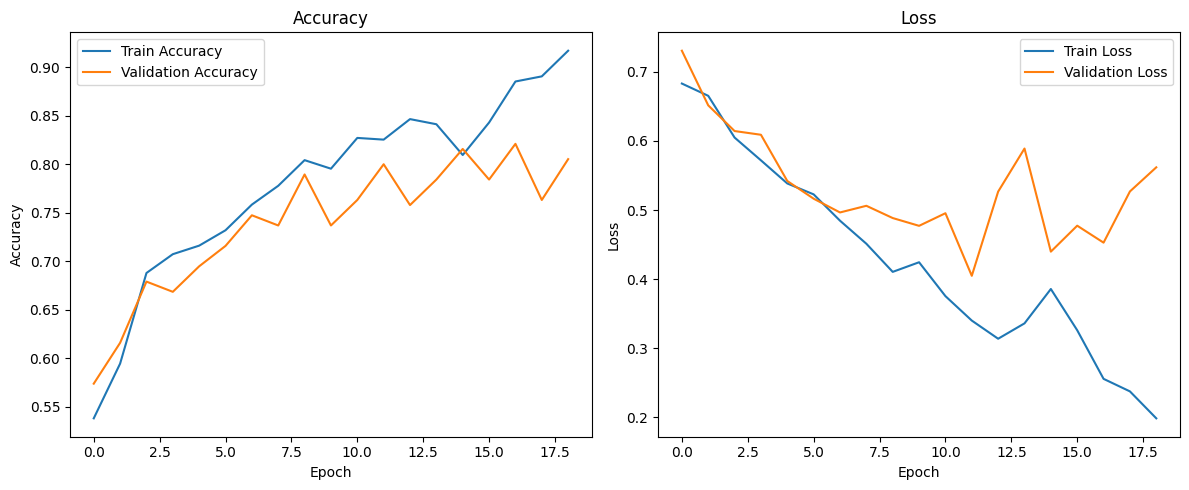

In [ ]:
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_normalized, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_normalized)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_normalized, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

input_shape = X_train_normalized.shape[1:] # (Hauteur, Largeur, Canaux)
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid') 
])

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
)
model.summary()

In [ ]:
epochs = 30

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

print("\nÉvaluation sur l'ensemble de test:")
results = model.evaluate(test_dataset)
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"Precision: {results[2]:.4f}")
print(f"Recall: {results[3]:.4f}")